In [9]:
!pip install -q pytorch-tabnet

In [13]:
pip install -q pytorch-lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --upgrade "s3fs>=2023.6.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 168.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.2.0
    Uninstalling fsspec-2025.2.0:
      Successfully uninstalled fsspec-2025.2.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.37.7
    Uninstalling botocore-1.37.7:
      Successfully uninstalled botocore-1.37.7
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.4.2
    Uninstalling s3fs-0.4.2:
      Successfully uninstalled s3fs-0.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.38.7 requires botocore==1.37.7, but you have botocore 1.37.1 which is incompatible.
boto3 1.37.7 requires botocore<1.38.0,>=1.37.7, but you have botocore 1.37.1 which is incompatible.


In [95]:
import psutil
ram = psutil.virtual_memory()
print(f"Used: {ram.used / 1e9:.2f} GB")
print(f"Available: {ram.available / 1e9:.2f} GB")
print(f"Total: {ram.total / 1e9:.2f} GB")

Used: 87.29 GB
Available: 111.52 GB
Total: 200.47 GB


In [82]:
#check gpu
!nvidia-smi

Wed Mar 26 23:48:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1B.0 Off |                    0 |
|  0%   27C    P0             58W /  300W |     497MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

 Check files in S3

In [1]:
import boto3

bucket = "fireguarddata"
prefix = "data/preprocessed_data/"

s3 = boto3.client("s3")

# List the files in the preprocessed folder
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

print("Saved files:")
for obj in response.get("Contents", []):
    print(obj["Key"])


Saved files:
data/preprocessed_data/df_all_years_cleaned.csv
data/preprocessed_data/df_full_preprocessed.csv
data/preprocessed_data/test.csv
data/preprocessed_data/train.csv
data/preprocessed_data/val.csv


### Load Train, Val, Test in Chunks from S3

In [1]:
import pandas as pd
from tqdm import tqdm

# Paths
base_path = "s3://fireguarddata/data/preprocessed_data/"
paths = {
    "train": f"{base_path}train.csv",
    "val": f"{base_path}val.csv",
    "test": f"{base_path}test.csv"
}

# Function to load in chunks
def load_csv_in_chunks(path, chunksize= 1_000_000):
    chunks = []
    for chunk in tqdm(pd.read_csv(path, chunksize=chunksize, storage_options={"anon": False}), desc=f"Loading {path}"):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Load
train_df = load_csv_in_chunks(paths["train"])
val_df = load_csv_in_chunks(paths["val"])
test_df = load_csv_in_chunks(paths["test"])


Loading s3://fireguarddata/data/preprocessed_data/train.csv: 65it [08:31,  7.87s/it]
Loading s3://fireguarddata/data/preprocessed_data/val.csv: 9it [01:05,  7.32s/it]
Loading s3://fireguarddata/data/preprocessed_data/test.csv: 9it [01:00,  6.68s/it]


In [35]:
print("Columns in Train:")
print(train_df.columns.tolist())

print("\nColumns in Val:")
print(val_df.columns.tolist())

print("\nColumns in Test:")
print(test_df.columns.tolist())

Columns in Train:
['latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl', 'cl', 'swvl1', 'daynight', 'tvh', 'ie', 'd2m', 't2m', 'tcc', 'tcrw', 'rsn', 'sd', 'tsn', 'slt', 'year', 'month', 'day', 'wind_speed', 'wind_direction', 'fuel_load', 'fire_occurrence']

Columns in Val:
['latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl', 'cl', 'swvl1', 'daynight', 'tvh', 'ie', 'd2m', 't2m', 'tcc', 'tcrw', 'rsn', 'sd', 'tsn', 'slt', 'year', 'month', 'day', 'wind_speed', 'wind_direction', 'fuel_load', 'fire_occurrence']

Columns in Test:
['latitude', 'longitude', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv', 'tvl', 'cl', 'swvl1', 'daynight', 'tvh', 'ie', 'd2m', 't2m', 'tcc', 'tcrw', 'rsn', 'sd', 'tsn', 'slt', 'year', 'month', 'day', 'wind_speed', 'wind_direction', 'fuel_load', 'fire_occurrence']


### Separate Features and Target
also, this converts to NumPy arrays which TabNet prefers.

drop columns

In [27]:
# Drop columns
cols_to_drop = ["number", "surface", "depthBelowLandLayer"]

train_df.drop(columns=cols_to_drop, inplace=True, errors="ignore")
val_df.drop(columns=cols_to_drop, inplace=True, errors="ignore")
test_df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

seperate feature and target features

In [29]:
X_train = train_df.drop(columns=["fire_occurrence"]).values
y_train = train_df["fire_occurrence"].values

X_val = val_df.drop(columns=["fire_occurrence"]).values
y_val = val_df["fire_occurrence"].values

X_test = test_df.drop(columns=["fire_occurrence"]).values
y_test = test_df["fire_occurrence"].values


In [30]:
print("Shapes of split datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Shapes of split datasets:
X_train: (64434342, 27), y_train: (64434342,)
X_val:   (8054293, 27), y_val:   (8054293,)
X_test:  (8054293, 27), y_test:  (8054293,)


## MODEL TRAINING FUNCTION

Step 2: Function to Train TabNet Model
This function trains TabNet using GPU, selects the best features, and saves the model. 50 epochs. try 10

In [36]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import torch
import s3fs
import joblib
import io

def train_tabnet(X_train, y_train, X_val, y_val, epochs=10, batch_size=4096, lr=0.03, s3_model_path="s3://fireguarddata/models/tabnet/tabnet_model.pkl"):
    """
    Train a TabNet model with GPU support, class weights, and save to S3.
    """
    # Select device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    # Compute sample weights for class balancing
    #sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

    # Initialize TabNet model
    tabnet = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="entmax", # Better for feature selection
        device_name=device
    )

    # Fit model with early stopping
    tabnet.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["balanced_accuracy"], # Use balanced accuracy for evaluation
        max_epochs=epochs,
        batch_size=batch_size,
        patience=2,
        #weights=sample_weights
        verbose=True  # Add this for detailed logs
    )

    # Save to S3 using s3fs
    fs = s3fs.S3FileSystem(anon=False)
    buffer = io.BytesIO()
    joblib.dump(tabnet, buffer)
    buffer.seek(0)
    with fs.open(s3_model_path, "wb") as f:
        f.write(buffer.read())

    print(f"Model saved to: {s3_model_path}")
    return tabnet

### Initialize Your Model

In [34]:
tabnet_model_nb = train_tabnet(X_train, y_train, X_val, y_val, epochs=10, s3_model_path="s3://fireguarddata/models/tabnet/tabnet_nb_checkpt.pkl")

Training on device: cuda


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


RuntimeError: number of categories cannot exceed 2^24

### Sample training on 2million rows

In [37]:
import numpy as np

# Randomly sample 2 million rows from X_train and y_train
sample_size = 2_000_000
sample_idx = np.random.choice(len(X_train), size=sample_size, replace=False)

X_train_sampled = X_train[sample_idx]
y_train_sampled = y_train[sample_idx]


#### Sample Training Evaluation
Once training is done, you can access:

1. tabnet.history

2. tabnet._saved_metrics
This is another source for saved metrics (sometimes redundant with history).

evaluate_tabnet_model - wraps up training + evaluation + plotting together after training


 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98   6304436
           1       0.92      0.91      0.91   1749857

    accuracy                           0.96   8054293
   macro avg       0.94      0.94      0.94   8054293
weighted avg       0.96      0.96      0.96   8054293

 Accuracy: 0.9618125389776607
 ROC AUC: 0.9894141215914374


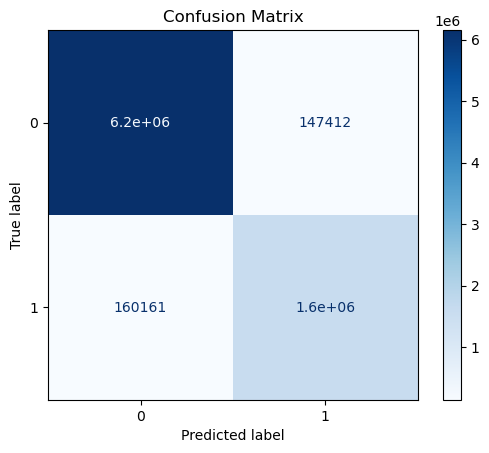

KeyError: 0

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay

def evaluate_tabnet_model(model, X_val, y_val):
    # ===== Predict =====
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]  # For ROC AUC

    # ===== Metrics =====
    print("\n Classification Report:")
    print(classification_report(y_val, y_pred))

    print(" Accuracy:", accuracy_score(y_val, y_pred))
    print(" ROC AUC:", roc_auc_score(y_val, y_proba))

    # ===== Confusion Matrix =====
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # ===== Training History =====
    if hasattr(model, "history"):
        history = model.history
        val_scores = [ep.get("balanced_accuracy", 0) for ep in history]

        plt.plot(val_scores, marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Balanced Accuracy")
        plt.title("Validation Balanced Accuracy per Epoch")
        plt.grid(True)
        plt.show()
    else:
        print(" No training history found on model.")

# Call this with your trained model
evaluate_tabnet_model(tabnet_sampled_model, X_val, y_val)

### deeper error analysis next!

#### Export Predictions with Coordinates & Extra Info

In [40]:
# Predict probabilities and labels
y_pred = tabnet_sampled_model.predict(X_val)
y_proba = tabnet_sampled_model.predict_proba(X_val)[:, 1]

# Load matching lat/lon and relevant info from the original val_df
val_df_subset = val_df.copy()
val_df_subset = val_df_subset.reset_index(drop=True)

# Sanity check to match lengths
assert len(val_df_subset) == len(y_pred)

# Add predictions
val_df_subset["fire_predicted"] = y_pred
val_df_subset["fire_probability"] = y_proba

# Select columns to export
columns_to_export = [
    "latitude", "longitude", "fuel_load", "wind_speed", "wind_direction",
    "fire_occurrence", "fire_predicted", "fire_probability"
]

export_df = val_df_subset[columns_to_export]
export_df["fire_probability"] = export_df["fire_probability"].round(6)

# Save to S3 (or local if testing)
export_path = "s3://fireguarddata/outputs/tabnet_val_predictions.csv"
export_df.to_csv(export_path, index=False, storage_options={"anon": False})

print(f"Exported prediction results to: {export_path}")


Exported prediction results to: s3://fireguarddata/outputs/tabnet_val_predictions.csv


#### Inspecting Validation Predictions
- fire_occurrence is the actual label (ground truth)
- fire_predicted is the model's prediction (0 or 1)
- fire_probability is the model's confidence (i.e., probability of class 1, fire)

In [44]:
export_df["fire_probability"] = export_df["fire_probability"].round(6)

export_df.head(30)

/tmp/ipykernel_21734/4105568396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df["fire_probability"] = export_df["fire_probability"].round(6)


,latitude,longitude,fuel_load,wind_speed,wind_direction,fire_occurrence,fire_predicted,fire_probability
0,0.574675,-1.060801,0.393825,0.064947,-0.301161,0,1,0.822116
1,-0.920354,1.186826,-1.921683,-1.128431,-0.591952,0,0,0.000027
2,1.602508,-1.451693,0.993109,1.469954,0.511885,1,1,0.998699
3,-1.761308,1.675441,0.817307,-0.210114,-0.030735,0,0,0.000002
4,0.761554,-0.963078,0.152625,0.132015,1.544556,0,0,0.201337
5,-1.294111,1.675441,-1.921683,0.689928,0.175961,0,0,0.004361
6,-0.733475,1.089103,-1.921683,-0.651393,0.572192,0,0,0.010698
7,1.415629,-1.451693,0.418716,-0.747253,-1.805911,1,1,0.998867
8,-1.387551,2.164056,0.188018,1.578180,0.890270,0,0,0.000018
9,1.135311,-1.256247,0.170151,-0.039795,-0.118843,1,1,0.995958


#### ROC CURVE

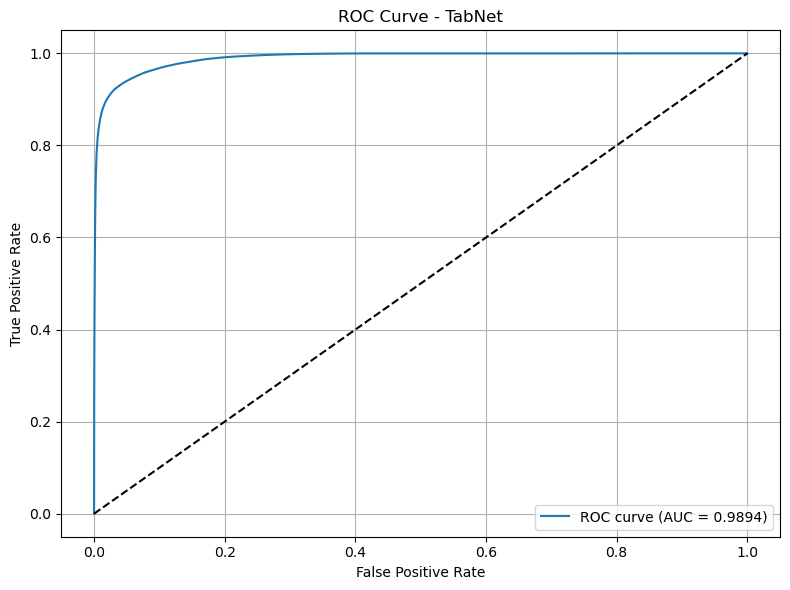

In [45]:
from sklearn.metrics import roc_curve, auc

# Get probabilities
y_score = tabnet_sampled_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - TabNet")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Plot Feature Importance
Perfect! Since you loaded the data from train_df, val_df, and test_df, you can extract feature_names like this to fix the NameError

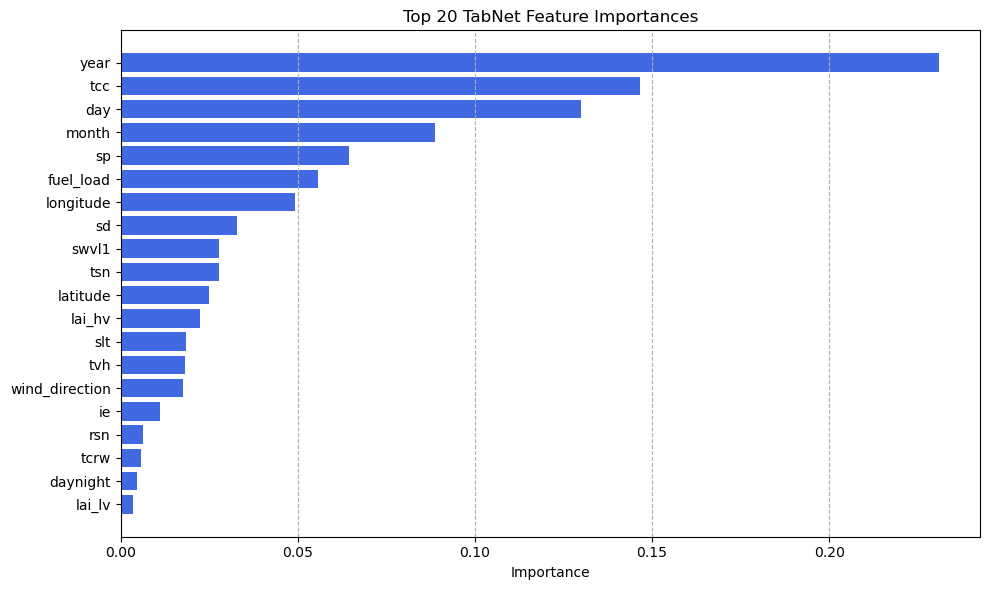

In [50]:
import matplotlib.pyplot as plt

# Get feature names from the original DataFrame
feature_names = train_df.drop(columns=["fire_occurrence"]).columns.tolist()

# Feature Importance
feat_importances = tabnet_sampled_model.feature_importances_
top_features = sorted(zip(feature_names, feat_importances), key=lambda x: x[1], reverse=True)

# Plot Top 15
top_n = 20
labels, values = zip(*top_features[:top_n])
plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], values[::-1], color="royalblue")
plt.title("Top 20 TabNet Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True, axis="x", linestyle="--")
plt.show()


#### Confusion Matrix

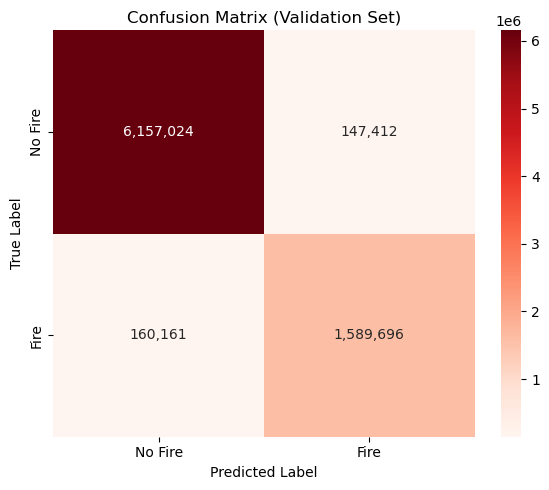

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = ["No Fire", "Fire"]

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=",.0f", cmap="Reds", xticklabels=labels, yticklabels=labels)

# Axis labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()


#### Classification Report

In [52]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["No Fire", "Fire"]))


Classification Report:

              precision    recall  f1-score   support

     No Fire       0.97      0.98      0.98   6304436
        Fire       0.92      0.91      0.91   1749857

    accuracy                           0.96   8054293
   macro avg       0.94      0.94      0.94   8054293
weighted avg       0.96      0.96      0.96   8054293



#### ROC CURVE
Great for visualizing true positive rate vs false positive rate.

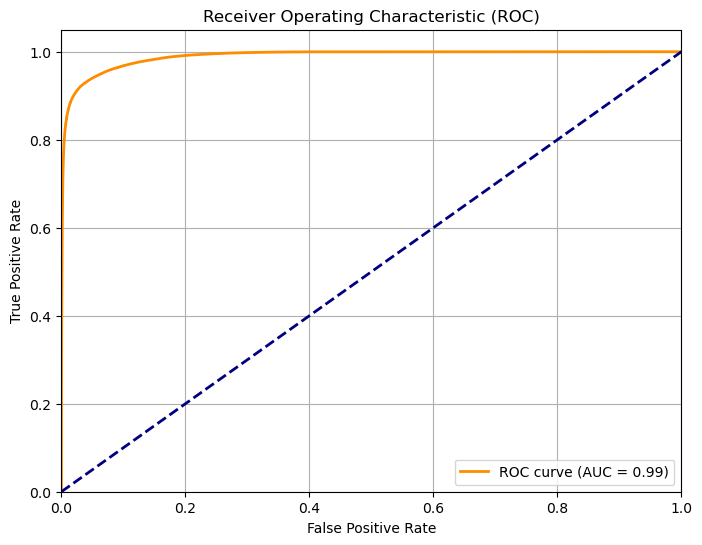

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_proba = tabnet_sampled_model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Precision Recall Curve
The Precision-Recall (PR) curve is especially useful when dealing with imbalanced classification, which is often the case with fire occurrence prediction.

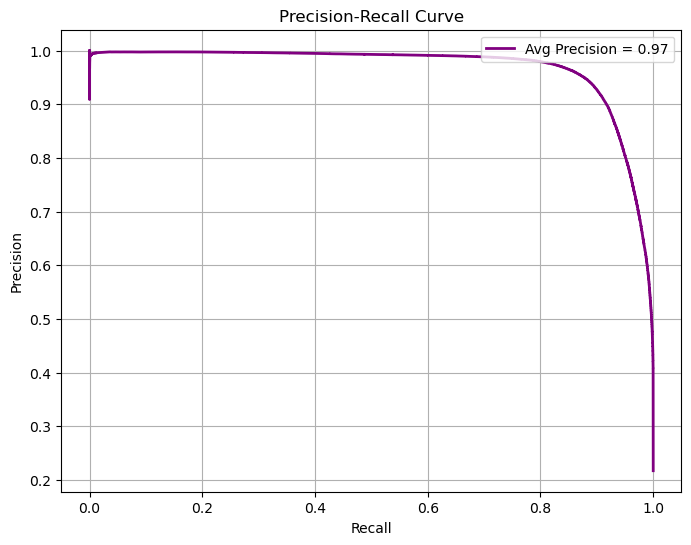

In [55]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities
y_proba = tabnet_sampled_model.predict_proba(X_val)[:, 1]

# Compute precision-recall pairs
precision, recall, _ = precision_recall_curve(y_val, y_proba)
avg_precision = average_precision_score(y_val, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="purple", lw=2, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


####  Misclassification Analysis
View samples that were incorrectly predicted (e.g. false positives or false negatives):

In [54]:
# Get misclassified indices
misclassified_idx = np.where(y_val != y_pred)[0]

# Take a peek at a few
val_df.iloc[misclassified_idx].head(20)

#save as csv

,latitude,longitude,u10,v10,sp,lai_hv,lai_lv,tvl,cl,swvl1,...,sd,tsn,slt,year,month,day,wind_speed,wind_direction,fuel_load,fire_occurrence
0,0.574675,-1.060801,0.727313,-0.778570,-0.035147,-0.104790,1.050029,-0.399438,0.272293,-0.483929,...,-0.183882,0.086433,-0.852574,0.444995,0.348789,1.699999,0.064947,-0.301161,0.393825,0
14,-0.079400,-0.376741,0.627278,0.660385,1.387713,-0.566945,1.064485,0.169226,-0.195299,0.828083,...,-0.183882,0.086539,-0.852574,1.084728,-1.832033,1.471428,-0.078977,0.474662,0.018352,0
19,-1.480990,0.991380,-0.044583,0.367079,0.862346,1.437815,1.568966,1.306553,1.220701,-0.595886,...,-0.183882,0.086433,-0.852574,0.125129,-0.274303,1.585713,-0.956468,0.688168,1.906629,0
33,0.014039,0.209597,-0.145109,0.219958,-2.186228,0.659419,1.708909,1.306553,-0.339887,0.346227,...,-0.183882,0.086326,1.304576,0.444995,0.037243,0.671428,-1.186730,0.695078,1.327121,1
43,0.200918,-0.963078,2.435506,0.272794,1.178746,-0.428702,1.449739,-0.399438,-0.030119,-0.117057,...,-0.183882,0.085257,-0.852574,1.084728,0.037243,-0.928573,1.954157,0.151059,0.308925,1
68,-0.079400,-0.181295,-1.294256,0.910926,1.405505,-0.259941,1.327829,0.169226,-0.102231,1.164006,...,-0.183882,0.012573,-0.852574,1.404594,-0.897395,-1.614287,0.185797,1.521378,0.392666,1
73,0.854993,-0.474464,-0.885813,0.051130,-0.851434,0.473666,0.076091,1.496108,-0.317562,0.390433,...,-0.183882,0.086539,1.304576,1.404594,0.348789,-0.471430,-0.825411,1.900432,0.426422,0
97,0.200918,-0.474464,0.295525,-0.276698,1.408058,-0.538323,0.609633,-0.399438,-0.275788,-0.441981,...,-0.183882,0.086646,-0.852574,0.444995,0.660335,1.585713,-0.741626,-0.154500,-0.166111,0
98,-1.761308,1.382272,-1.510930,-0.114139,-0.052902,1.142937,-0.863123,0.358780,-0.384253,-0.089882,...,-0.183882,0.085577,-0.852574,-0.194738,1.594973,0.328570,-0.030381,-1.781572,0.549988,1
132,-0.079400,0.014151,1.278760,-0.905748,0.351978,-0.255570,0.870890,-0.399438,-0.395543,-0.227566,...,-0.183882,0.086326,-0.852574,1.404594,0.037243,-1.271430,0.748646,-0.226867,0.187199,1


####  Inspect Misclassifications with Predictions & Probabilities
We’ll now be able to analyze:
- Whether the model was overconfident but wrong
- If certain feature values (e.g. wind speed, fuel load) show up repeatedly in misclassifications
- can export this subset to S3 as a CSV for further inspection or visualization.

In [56]:
# Get predicted classes and probabilities
y_pred = tabnet_sampled_model.predict(X_val)
y_proba = tabnet_sampled_model.predict_proba(X_val)[:, 1]  # probability of class 1 (fire)

# Add predictions to val_df (create a copy to avoid modifying original)
val_results = val_df.copy()
val_results["fire_predicted"] = y_pred
val_results["fire_probability"] = y_proba

# Find misclassified rows
misclassified_idx = np.where(val_results["fire_occurrence"] != val_results["fire_predicted"])[0]

# View some misclassified samples
val_results.iloc[misclassified_idx].sort_values("fire_probability", ascending=False).head(20)


,latitude,longitude,u10,v10,sp,lai_hv,lai_lv,tvl,cl,swvl1,...,slt,year,month,day,wind_speed,wind_direction,fuel_load,fire_occurrence,fire_predicted,fire_probability
730642,1.415629,-1.353970,-0.517060,-0.486685,-0.304717,1.164052,-1.331239,-1.72632,-0.409979,-0.102504,...,-0.852574,1.084728,0.660335,-1.728573,-0.925509,-1.130060,0.353250,0,1,0.999910
3501624,1.415629,-1.353970,0.997635,0.106149,-0.186986,1.127925,-1.331537,-1.72632,-0.409979,0.309799,...,-0.852574,1.084728,0.660335,-1.042859,0.102982,0.147993,0.323245,0,1,0.999886
4483775,1.415629,-1.353970,-0.580826,-0.004556,-0.191347,1.129904,-1.331537,-1.72632,-0.409979,0.355774,...,-0.852574,1.084728,0.660335,-1.042859,-1.221428,1.926262,0.324882,0,1,0.999837
6586606,1.415629,-1.353970,-0.506158,-0.006914,-0.187014,1.129657,-1.331537,-1.72632,-0.409979,0.355348,...,-0.852574,1.084728,0.660335,-1.042859,-1.316622,1.910315,0.324677,0,1,0.999836
6272889,1.415629,-1.353970,1.137556,0.194140,-0.215518,1.139225,-1.331388,-1.72632,-0.409979,0.495246,...,-0.852574,1.084728,0.660335,-1.271430,0.295517,0.178652,0.332656,0,1,0.999813
6503030,1.602508,-1.353970,-0.485484,-0.322241,-0.166586,1.158691,-1.520960,-1.72632,-0.411896,0.842817,...,1.304576,1.084728,0.660335,-0.585716,-1.133545,-1.201792,0.262008,0,1,0.999784
3692594,1.602508,-1.353970,-0.107957,-0.377251,-0.171278,1.158196,-1.520960,-1.72632,-0.411896,0.835905,...,1.304576,1.084728,0.660335,-0.585716,-1.059332,-0.557543,0.261598,0,1,0.999783
5796358,1.602508,-1.353970,-0.970217,-0.413370,-0.157404,1.160753,-1.520960,-1.72632,-0.411896,0.831492,...,1.304576,1.084728,0.660335,-0.585716,-0.591689,-1.503055,0.263712,0,1,0.999766
1934752,1.602508,-1.353970,1.245189,-0.544764,-0.192305,1.157041,-1.520960,-1.72632,-0.411896,0.773790,...,1.304576,1.084728,0.660335,-0.585716,0.518472,-0.113645,0.260644,0,1,0.999734
6685949,1.602508,-1.353970,-0.958896,-1.235338,-0.172255,1.149700,-1.520960,-1.72632,-0.411896,0.706591,...,1.304576,1.084728,0.660335,-0.357144,0.197280,-1.167803,0.254574,0,1,0.999697


##
---

## Here are 7–9 key observations based on your sampled TabNet model's evaluation results (confusion matrix, ROC curve, classification report, and misclassified samples):

Strong Overall Performance:
The model achieved a high overall accuracy of 96%, with particularly strong performance on the majority class ("No Fire"). The precision (0.97) and recall (0.98) for "No Fire" indicate that the model rarely mislabels fire-absent cases.

Handling Class Imbalance Well:
Despite the class imbalance (only ~22% fires), the model maintains a good recall of 91% and precision of 92% for the 'Fire' class, meaning it's effective at detecting fires without too many false alarms.

AUC = 0.99 (Excellent):
The ROC AUC of 0.99 shows that the model separates classes almost perfectly. It means across various thresholds, the true positive rate remains much higher than the false positive rate.

Confusion Matrix Insight:
There are ~147k false positives and ~160k false negatives — both fairly small compared to 6M+ true negatives and 1.5M+ true positives. However, the false negatives (missed fires) are more critical for fire detection tasks.

Misclassifications with High Confidence:
A few false positives had very high predicted probabilities (e.g., 0.99), indicating the model was confident but wrong. These might be edge cases or data points near the decision boundary — potentially useful for further analysis or active learning.

Lat/Lon Clusters in Misclassifications:
Some misclassified points cluster around certain lat/lon regions — suggesting possible spatial biases or missing geographic features. These could be explored on a map for anomaly patterns.

Feature Importance Value:
While not shown in this specific output, prior plots indicated that features like fuel load, wind speed, and temperature have strong predictive power. That aligns well with fire science domain knowledge.

Threshold Tuning Opportunity:
Given the small but impactful number of false negatives, you might improve fire recall further by lowering the classification threshold (e.g., from 0.5 → 0.4), depending on the cost of false alarms.

Great Start, Expand Next:
This sampled run offers a solid prototype. Training on the full dataset (with multi-GPU DDP strategy) should yield even better generalization — plus enable advanced post-processing like calibration, uncertainty estimation, and spatial visualization.

### train_tabnet_weights Function

In [38]:
tabnet_sampled_model = train_tabnet(X_train_sampled,y_train_sampled,X_val,y_val,epochs=10,batch_size=8192,
    s3_model_path="s3://fireguarddata/models/tabnet/tabnet_sampled_model.pkl")


Training on device: cuda


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.18763 | val_0_balanced_accuracy: 0.91208 |  0:03:00s
epoch 1  | loss: 0.13354 | val_0_balanced_accuracy: 0.92674 |  0:05:37s
epoch 2  | loss: 0.11936 | val_0_balanced_accuracy: 0.92995 |  0:08:14s
epoch 3  | loss: 0.11144 | val_0_balanced_accuracy: 0.94254 |  0:10:51s
epoch 4  | loss: 0.10601 | val_0_balanced_accuracy: 0.93818 |  0:13:28s
epoch 5  | loss: 0.10285 | val_0_balanced_accuracy: 0.94023 |  0:16:05s

Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.94254


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model saved to: s3://fireguarddata/models/tabnet/tabnet_sampled_model.pkl


In [78]:
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import s3fs
import joblib
import io
import matplotlib.pyplot as plt

#top level custom loss function to prevent error
def make_weighted_loss(class_weights_tensor):
    def loss_fn(y_pred, y_true):
        return F.cross_entropy(y_pred, y_true, weight=class_weights_tensor)
    return loss_fn
#training function with weighted loss and s3 save
#train the model
def train_tabnet_weights(X_train, y_train, X_val, y_val, epochs=10, batch_size=8192, lr=0.03,
                         s3_model_path="s3://fireguarddata/models/tabnet/tabnet_model.pkl"):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    # Compute class weights (NOT per sample, so memory-safe)
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    loss_fn = make_weighted_loss(class_weights_tensor)

    # Initialize model
    tabnet = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="entmax",
        device_name=device
    )

    # Fit
    tabnet.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["balanced_accuracy"],
        max_epochs=epochs,
        batch_size=batch_size,
        patience=2,
        loss_fn=loss_fn
    )

    # REMOVE loss_fn reference from model (makes it picklable)
    tabnet.loss_fn = None #  Only used during training
    
    # Save to S3
    fs = s3fs.S3FileSystem(anon=False)
    buffer = io.BytesIO()
    joblib.dump(tabnet, buffer)  #  Will now work
    buffer.seek(0)
    with fs.open(s3_model_path, "wb") as f:
        f.write(buffer.read())

    print(f" Model saved to: {s3_model_path}")
    return tabnet


In [79]:
tabnet_sampled_model_weights = train_tabnet_weights(
    X_train_sampled, y_train_sampled,
    X_val, y_val,
    epochs=10,
    batch_size=8192,
    s3_model_path="s3://fireguarddata/models/tabnet/tabnet_sampled_model_weights.pkl"
)


Training on device: cuda


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.23567 | val_0_balanced_accuracy: 0.92263 |  0:02:39s
epoch 1  | loss: 0.18166 | val_0_balanced_accuracy: 0.9283  |  0:05:19s
epoch 2  | loss: 0.16756 | val_0_balanced_accuracy: 0.93361 |  0:07:57s
epoch 3  | loss: 0.16457 | val_0_balanced_accuracy: 0.92841 |  0:10:35s
epoch 4  | loss: 0.20635 | val_0_balanced_accuracy: 0.91742 |  0:13:13s

Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.93361


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 Model saved to: s3://fireguarddata/models/tabnet/tabnet_sampled_model_weights.pkl



📋 Classification Report:

              precision    recall  f1-score   support

     No Fire       0.98      0.93      0.96   6304436
        Fire       0.80      0.93      0.86   1749857

    accuracy                           0.93   8054293
   macro avg       0.89      0.93      0.91   8054293
weighted avg       0.94      0.93      0.94   8054293



<Figure size 600x600 with 0 Axes>

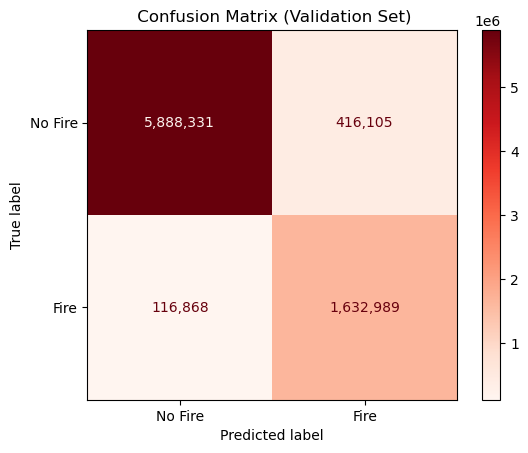

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = tabnet_sampled_model_weights.predict(X_val)

# Classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["No Fire", "Fire"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])

# Plot nicely
plt.figure(figsize=(6,6))
disp.plot(cmap="Reds", values_format=",.0f")
plt.title(" Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()


**Performance Comparison Tabnet model with weights:**

The weighted model (with class weights) shows improved sensitivity to fire detection:

- Recall for Fire class increased from 91% → 93%, meaning the model is catching more actual fire cases.

- However, precision for Fire dropped from 92% → 80%, meaning it’s generating more false positives (labeling "No Fire" as fire).

Overall balanced accuracy is similar or slightly better, but the tradeoff favors catching more fires, which is often desirable in real-world fire prediction systems.

### Train Tabnet with Focal Loss
Focal loss is especially useful for class imbalance because it focuses training on misclassified (hard) examples — like rare fire events.
- gamma=2.0 is the focusing parameter (increase it to focus more on hard samples).
- alpha balances classes; we derive it from inverse class frequency, but you can set manually (e.g., alpha=[0.25, 0.75]).
- Works well with large imbalances (e.g. fire:non-fire).

gamma	Controls how much to focus on misclassified/hard examples. Higher = more focus.	1.5 – 3.0
- alpha	Class balancing. Helps increase weight of minority class (fires).	0.2 – 0.4

In [83]:
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix
import s3fs
import joblib
import io

# === Focal Loss === #
def focal_loss_fn(gamma=2.0, alpha=None):
    def loss_fn(y_pred, y_true):
        # y_pred: raw logits or probabilities (shape: batch_size x num_classes)
        # y_true: long tensor (shape: batch_size)
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.float()
        else:
            y_pred = torch.tensor(y_pred, dtype=torch.float32)

        y_true = y_true.long()
        logp = F.log_softmax(y_pred, dim=1)
        p = torch.exp(logp)

        # One-hot encoding of targets
        y_true_onehot = F.one_hot(y_true, num_classes=y_pred.shape[1]).float()

        if alpha is not None:
            alpha_tensor = torch.tensor(alpha).to(y_pred.device)
            logp = logp * alpha_tensor

        loss = - (1 - p) ** gamma * logp
        loss = (loss * y_true_onehot).sum(dim=1)
        return loss.mean()
    
    return loss_fn

# === Training Function with Focal Loss === #
def train_tabnet_focal(X_train, y_train, X_val, y_val, epochs=10, batch_size=8192, lr=0.03,
                       s3_model_path="s3://fireguarddata/models/tabnet/tabnet_focal_loss.pkl"):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    # Optional class weights (alpha in focal loss) — you can remove if undesired
    classes = np.unique(y_train)
    class_weights = torch.tensor(
        np.bincount(y_train) / len(y_train), dtype=torch.float32
    )
    alpha = (1.0 - class_weights).tolist()  # Inverse frequency as alpha

    # Focal loss with gamma=2.0 and optional alpha
    loss_fn = focal_loss_fn(gamma=2.0, alpha=alpha)

    # Initialize TabNet model
    tabnet = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="entmax",
        device_name=device
    )

    # Fit
    tabnet.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["balanced_accuracy"],
        max_epochs=epochs,
        batch_size=batch_size,
        patience=2,
        loss_fn=loss_fn
    )

    # Remove loss_fn to make model picklable
    tabnet.loss_fn = None

    # Save model to S3
    fs = s3fs.S3FileSystem(anon=False)
    buffer = io.BytesIO()
    joblib.dump(tabnet, buffer)
    buffer.seek(0)
    with fs.open(s3_model_path, "wb") as f:
        f.write(buffer.read())

    print(f"Model saved to: {s3_model_path}")
    return tabnet


In [84]:
tabnet_sampled_focal = train_tabnet_focal(
    X_train_sampled, y_train_sampled,
    X_val, y_val,
    epochs=10,
    batch_size=8192,
    s3_model_path="s3://fireguarddata/models/tabnet/tabnet_sampled_focal.pkl"
)


Training on device: cuda


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.02355 | val_0_balanced_accuracy: 0.91949 |  0:02:39s
epoch 1  | loss: 0.01689 | val_0_balanced_accuracy: 0.9293  |  0:05:19s
epoch 2  | loss: 0.01563 | val_0_balanced_accuracy: 0.93417 |  0:07:58s
epoch 3  | loss: 0.01481 | val_0_balanced_accuracy: 0.93809 |  0:10:37s
epoch 4  | loss: 0.0159  | val_0_balanced_accuracy: 0.92968 |  0:13:16s
epoch 5  | loss: 0.01486 | val_0_balanced_accuracy: 0.93914 |  0:15:55s
epoch 6  | loss: 0.01395 | val_0_balanced_accuracy: 0.93993 |  0:18:34s
epoch 7  | loss: 0.01512 | val_0_balanced_accuracy: 0.93358 |  0:21:14s
epoch 8  | loss: 0.01456 | val_0_balanced_accuracy: 0.93973 |  0:23:55s

Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.93993


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model saved to: s3://fireguarddata/models/tabnet/tabnet_sampled_focal.pkl


### Visualizing Classifications from Focal Loss Model


 Classification Report (Focal Loss):

              precision    recall  f1-score   support

     No Fire       0.99      0.93      0.96   6304436
        Fire       0.79      0.95      0.86   1749857

    accuracy                           0.93   8054293
   macro avg       0.89      0.94      0.91   8054293
weighted avg       0.94      0.93      0.94   8054293



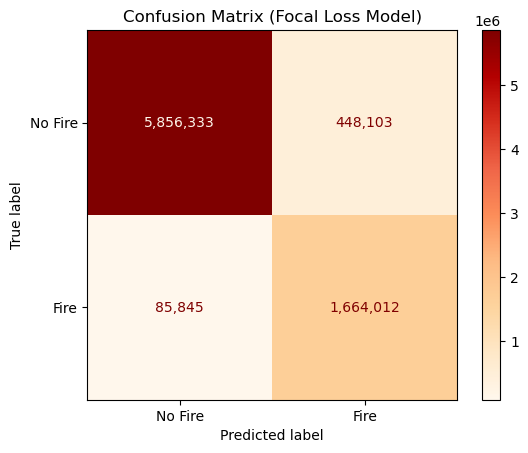

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict and Probabilities
y_pred_focal = tabnet_sampled_focal.predict(X_val)
y_proba_focal = tabnet_sampled_focal.predict_proba(X_val)[:, 1]

# Classification Report
print("\n Classification Report (Focal Loss):\n")
print(classification_report(y_val, y_pred_focal, target_names=["No Fire", "Fire"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_focal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="OrRd", values_format=",.0f")
plt.title("Confusion Matrix (Focal Loss Model)")
plt.grid(False)
plt.show()


#### Feature Importance

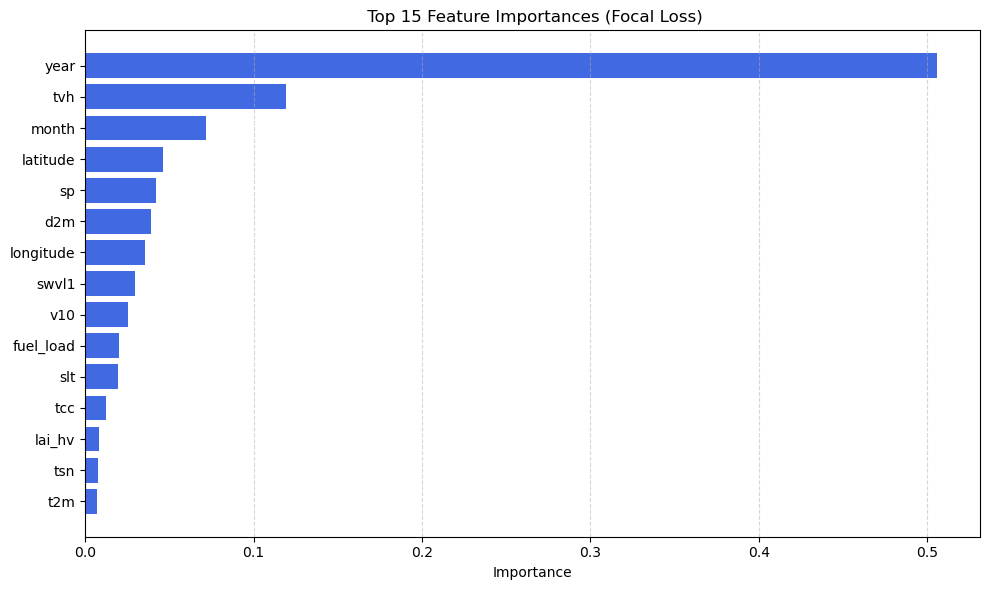

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
feat_importances = tabnet_sampled_focal.feature_importances_
top_n = 15

# Grab feature names from training data
feature_names = val_df.drop(columns=["fire_occurrence"]).columns.tolist()

# Sort & select top
top_features = sorted(zip(feature_names, feat_importances), key=lambda x: x[1], reverse=True)
labels, values = zip(*top_features[:top_n])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], values[::-1], color="royalblue")
plt.title(" Top 15 Feature Importances (Focal Loss)")
plt.xlabel("Importance")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### ROC Curve

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


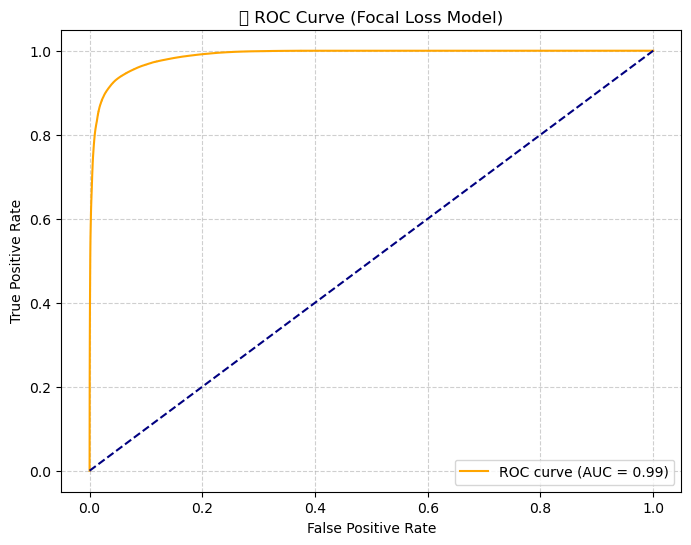

In [87]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
fpr, tpr, _ = roc_curve(y_val, y_proba_focal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🚀 ROC Curve (Focal Loss Model)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#### Actual Vs Predicted

In [90]:
# Make a copy of the validation set
val_df_full = val_df.copy()

# Add predictions and probabilities
val_df_full["fire_predicted"] = y_pred_focal
val_df_full["fire_probability"] = y_proba_focal

# Select the relevant columns
cols_to_display = [
    "latitude", "longitude",
    "wind_speed", "wind_direction", "fuel_load",
    "fire_occurrence", "fire_predicted", "fire_probability"
]

actual_vs_predicted_df = val_df_full[cols_to_display]

# Preview first few rows
actual_vs_predicted_df.head(15)


,latitude,longitude,wind_speed,wind_direction,fuel_load,fire_occurrence,fire_predicted,fire_probability
0,0.574675,-1.060801,0.064947,-0.301161,0.393825,0,1,0.619763
1,-0.920354,1.186826,-1.128431,-0.591952,-1.921683,0,0,0.023190
2,1.602508,-1.451693,1.469954,0.511885,0.993109,1,1,0.976201
3,-1.761308,1.675441,-0.210114,-0.030735,0.817307,0,0,0.004243
4,0.761554,-0.963078,0.132015,1.544556,0.152625,0,0,0.491386
5,-1.294111,1.675441,0.689928,0.175961,-1.921683,0,0,0.227164
6,-0.733475,1.089103,-0.651393,0.572192,-1.921683,0,0,0.213344
7,1.415629,-1.451693,-0.747253,-1.805911,0.418716,1,1,0.967305
8,-1.387551,2.164056,1.578180,0.890270,0.188018,0,0,0.003139
9,1.135311,-1.256247,-0.039795,-0.118843,0.170151,1,1,0.861728


In [ ]:
# Save locally
actual_vs_predicted_df.to_csv("actual_vs_predicted_focal.csv", index=False)

# Save to S3
with fs.open("s3://fireguarddata/analysis/actual_vs_predicted_focal.csv", "w") as f:
    actual_vs_predicted_df.to_csv(f, index=False)


#### Misclassified Samples (with Prediction + Probability)

In [88]:
# Misclassified indices
misclassified_idx = np.where(y_val != y_pred_focal)[0]

# Add predictions and probability to val_df for inspection
val_df_copy = val_df.copy()
val_df_copy["fire_predicted"] = y_pred_focal
val_df_copy["fire_probability"] = y_proba_focal

# Show sample misclassifications
val_df_copy.iloc[misclassified_idx].head(20)


,latitude,longitude,u10,v10,sp,lai_hv,lai_lv,tvl,cl,swvl1,...,slt,year,month,day,wind_speed,wind_direction,fuel_load,fire_occurrence,fire_predicted,fire_probability
0,0.574675,-1.060801,0.727313,-0.778570,-0.035147,-0.104790,1.050029,-0.399438,0.272293,-0.483929,...,-0.852574,0.444995,0.348789,1.699999,0.064947,-0.301161,0.393825,0,1,0.619763
14,-0.079400,-0.376741,0.627278,0.660385,1.387713,-0.566945,1.064485,0.169226,-0.195299,0.828083,...,-0.852574,1.084728,-1.832033,1.471428,-0.078977,0.474662,0.018352,0,1,0.524694
17,0.200918,-0.767633,-0.018138,-0.060820,1.423260,-0.416000,0.484146,-0.399438,1.710301,1.341205,...,-0.852574,1.404594,-1.832033,-1.728573,-1.203683,0.022303,-0.122399,0,1,0.511245
19,-1.480990,0.991380,-0.044583,0.367079,0.862346,1.437815,1.568966,1.306553,1.220701,-0.595886,...,-0.852574,0.125129,-0.274303,1.585713,-0.956468,0.688168,1.906629,0,1,0.525454
48,-1.107233,0.307320,-0.605863,-0.859495,-0.664306,0.710146,-0.056102,-1.347211,-0.411004,-0.335801,...,-0.852574,1.404594,0.348789,-1.271430,-0.433558,-1.077976,0.561445,0,1,0.516227
57,1.509069,-1.549416,-2.844428,-1.059821,0.863932,-0.612888,-1.540185,-1.726320,0.119883,0.284777,...,-0.852574,1.084728,-1.832033,0.899999,1.934765,-1.586573,-1.211448,0,1,0.510655
60,1.135311,-0.083572,1.352217,-1.062302,-1.153637,-1.726166,-0.896804,0.358780,-0.321672,-1.225408,...,0.226001,0.125129,0.348789,-1.271430,0.933397,-0.258722,-1.837464,0,1,0.626434
71,0.294357,-0.572187,0.883882,-0.319102,1.378236,-0.459139,0.847939,0.169226,0.283951,-0.809682,...,-0.852574,1.084728,0.660335,-1.385716,-0.007272,-0.062856,0.008396,0,1,0.590811
73,0.854993,-0.474464,-0.885813,0.051130,-0.851434,0.473666,0.076091,1.496108,-0.317562,0.390433,...,1.304576,1.404594,0.348789,-0.471430,-0.825411,1.900432,0.426422,0,1,0.660986
81,1.509069,-1.060801,0.002473,0.448977,-0.246013,0.219700,1.089523,-1.536765,-0.410691,2.203888,...,1.304576,1.084728,1.594973,-1.385716,-0.834411,0.693999,0.680170,0,1,0.538309


#### Focal Loss
The Focal Loss TabNet model shows strong performance in identifying fire events, particularly excelling in recall for the fire class (0.95) — meaning it correctly identifies 95% of actual fire occurrences. While the precision for the fire class is 0.79, this trade-off results in more false positives but fewer missed fires, which is often desirable in high-risk domains like wildfire detection. The f1-score for fire is 0.86, balancing both recall and precision effectively. Overall accuracy remains high at 93%, and the macro average f1-score is 0.91, indicating good performance across both classes. The confusion matrix supports this: while the model makes more false positives for non-fire areas, it dramatically reduces false negatives. This suggests the model is highly sensitive to fire risk, which aligns with the objective of minimizing undetected fires.

Compared to the baseline model without weighting, the focal loss version improves recall for the fire class (from ~91% to 95%) while maintaining comparable overall accuracy. Relative to the class-weighted model, focal loss slightly sacrifices precision (80% → 79%) but gains in fire recall (93% → 95%) — a critical improvement for applications where missing a fire is costlier than over-alerting. Overall, focal loss delivers the most fire-sensitive model, making it highly suitable when early detection is prioritized.


#### Tuned Focal Loss

In [92]:
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix
import s3fs
import joblib
import io

# === Focal Loss === #
import torch.nn.functional as F

# Custom focal loss with gamma and alpha
def make_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_pred, y_true):
        ce_loss = F.cross_entropy(y_pred, y_true, reduction='none')
        pt = torch.exp(-ce_loss)  # Prob of true class
        focal_term = (1 - pt) ** gamma

        # Apply alpha balancing
        if alpha is not None:
            alpha_tensor = torch.tensor([1 - alpha, alpha]).to(y_pred.device)
            at = alpha_tensor[y_true]
            loss = at * focal_term * ce_loss
        else:
            loss = focal_term * ce_loss
        return loss.mean()
    return focal_loss


# === Training Function with Focal Loss === #
def train_tabnet_focal_loss_tuned(X_train, y_train, X_val, y_val, epochs=10, batch_size=8192, lr=0.03,
                            gamma=2.0, alpha=0.25,
                            s3_model_path="s3://fireguarddata/models/tabnet/tabnet_focal_tuned.pkl"):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    loss_fn = make_focal_loss(gamma=gamma, alpha=alpha)

    # Initialize model
    tabnet = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="entmax",
        device_name=device
    )

    # Fit
    tabnet.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["balanced_accuracy"],
        max_epochs=epochs,
        batch_size=batch_size,
        patience=2,
        loss_fn=loss_fn
    )

    # Clear non-picklable object
    tabnet.loss_fn = None

    # Save model to S3
    fs = s3fs.S3FileSystem(anon=False)
    buffer = io.BytesIO()
    joblib.dump(tabnet, buffer)
    buffer.seek(0)
    with fs.open(s3_model_path, "wb") as f:
        f.write(buffer.read())

    print(f"Model saved to: {s3_model_path}")
    return tabnet


In [93]:
tabnet_focal_tuned = train_tabnet_focal_loss_tuned(
    X_train_sampled, y_train_sampled,
    X_val, y_val,
    gamma=2.5, alpha=0.3,
    batch_size=8192,
    epochs=10,
    s3_model_path="s3://fireguarddata/models/tabnet/tabnet_focal_gamma2.5_alpha0.3.pkl"
)

Training on device: cuda


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.02039 | val_0_balanced_accuracy: 0.85912 |  0:02:40s
epoch 1  | loss: 0.01375 | val_0_balanced_accuracy: 0.8893  |  0:05:18s
epoch 2  | loss: 0.01204 | val_0_balanced_accuracy: 0.89196 |  0:07:54s
epoch 3  | loss: 0.0113  | val_0_balanced_accuracy: 0.90817 |  0:10:33s
epoch 4  | loss: 0.01115 | val_0_balanced_accuracy: 0.9041  |  0:13:14s
epoch 5  | loss: 0.01074 | val_0_balanced_accuracy: 0.9047  |  0:15:51s

Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.90817


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model saved to: s3://fireguarddata/models/tabnet/tabnet_focal_gamma2.5_alpha0.3.pkl


#### Visualizing focal loss tuned model


 Classification Report (Focal Loss):

              precision    recall  f1-score   support

     No Fire       0.95      0.99      0.97   6304436
        Fire       0.95      0.83      0.88   1749857

    accuracy                           0.95   8054293
   macro avg       0.95      0.91      0.93   8054293
weighted avg       0.95      0.95      0.95   8054293



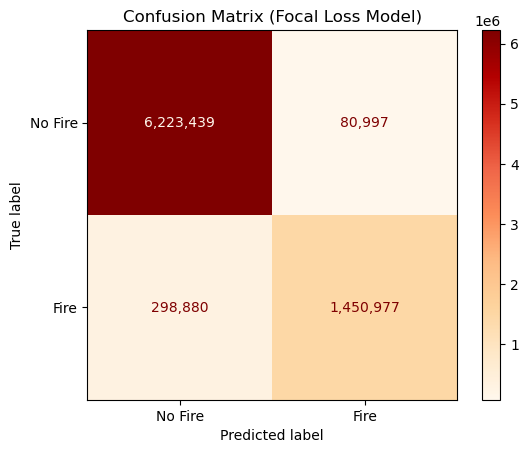

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict and Probabilities
y_pred_focal = tabnet_focal_tuned.predict(X_val)
y_proba_focal = tabnet_focal_tuned.predict_proba(X_val)[:, 1]

# Classification Report
print("\n Classification Report (Focal Loss Tuned):\n")
print(classification_report(y_val, y_pred_focal, target_names=["No Fire", "Fire"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_focal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="OrRd", values_format=",.0f")
plt.title("Confusion Matrix (Focal Loss Model Tuned)")
plt.grid(False)
plt.show()


Increasing gamma (→ 2.5) makes the loss focus too strongly on hard-to-classify samples.

This increased precision by being more cautious predicting fire (fewer false positives).

But it came at the cost of recall — it missed more actual fires (↓ 0.83 recall).



Step 3: Function to Evaluate Model Performance
This function evaluates classification performance using confusion matrix, precision-recall, and feature importance.